In [5]:
# for creating a responsive plot 
%matplotlib widget 

import numpy as np
import pandas as pd
import os
import nibabel as nib
import matplotlib.pyplot as plt
import pyvista as pv
import math
import vtk
import slicer
import PyQt5


In [6]:
def projection_to_2D(input_tensor: np.array, alpha: float, beta: float, dxc: float, dxd: float) -> np.array:

    #Convert angles to radians:
    alpha = math.radians(alpha)
    beta = math.radians(beta)

    #Projection
    p_base = np.sqrt(1 + np.tan(alpha)**2 + np.tan(beta)**2)
    p_x = -dxc*np.tan(alpha) / p_base
    p_y = dxc / p_base
    p_z = -dxc*np.tan(beta) / p_base
    p = np.array([p_x, p_y, p_z])

    #Axes of X-ray source coordinate system
    z_axis = -p / dxc
    x_axis = np.array([p_y / np.sqrt(p_x**2 + p_y**2), -p_x / np.sqrt(p_x**2 + p_y**2), 0])
    y_base = np.sqrt((p_x**2 + p_y**2)**2 + p_x**2*p_z**2 + p_y**2*p_z**2)
    y_axis = np.array([-p_x*p_z / y_base, -p_x*p_z / y_base, -p_x*p_z / y_base])

    coordinates = []
    for z in range(input_tensor.shape[2]):
        for x in range(input_tensor.shape[0]):
            for y in range(input_tensor.shape[1]):
                if input_tensor[x,y,z] != 0:
                    v_x = x * 0.37695312
                    v_y = y * 0.37695312
                    v_z = z * 0.5

                    #Convert point in volume to point in X-ray source
                    r_x = np.dot(np.array([v_x - p_x, 0, 0]), x_axis)
                    r_y = np.dot(np.array([0, v_y - p_y, 0]), y_axis)
                    r_z = np.dot(np.array([0, 0, v_z - p_z]), z_axis)   #(v_z - p_x) * z_axis
                    # r = (v_x - p_x) * x_axis + (v_y - p_y) * y_axis + (v_z - p_z) * z_axis
                    # r_x = r[0]
                    # r_y = r[1]
                    # r_z = r[2]
                    coordinates.append([r_x * dxd / r_z, r_y * dxd / r_z])

    coordinates = np.array(coordinates)
    coordinates[:,0] -= np.min(coordinates[:,0])
    coordinates[:,1] -= np.min(coordinates[:,1])
    coordinates = coordinates/np.max(coordinates) * 512
    return coordinates


In [7]:
import numpy as np
import pandas as pd
import os
import nibabel as nib
import matplotlib.pyplot as plt

cta_volume = nib.load('C:\\Users\\nasre\\Downloads\\ImageCAS\\1-200\\1-200\\1.label.nii.gz').get_fdata()
print(cta_volume.shape)

(512, 512, 275)


c:\Users\nasre\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\nasre\AppData\Local\Programs\Python\Python311\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


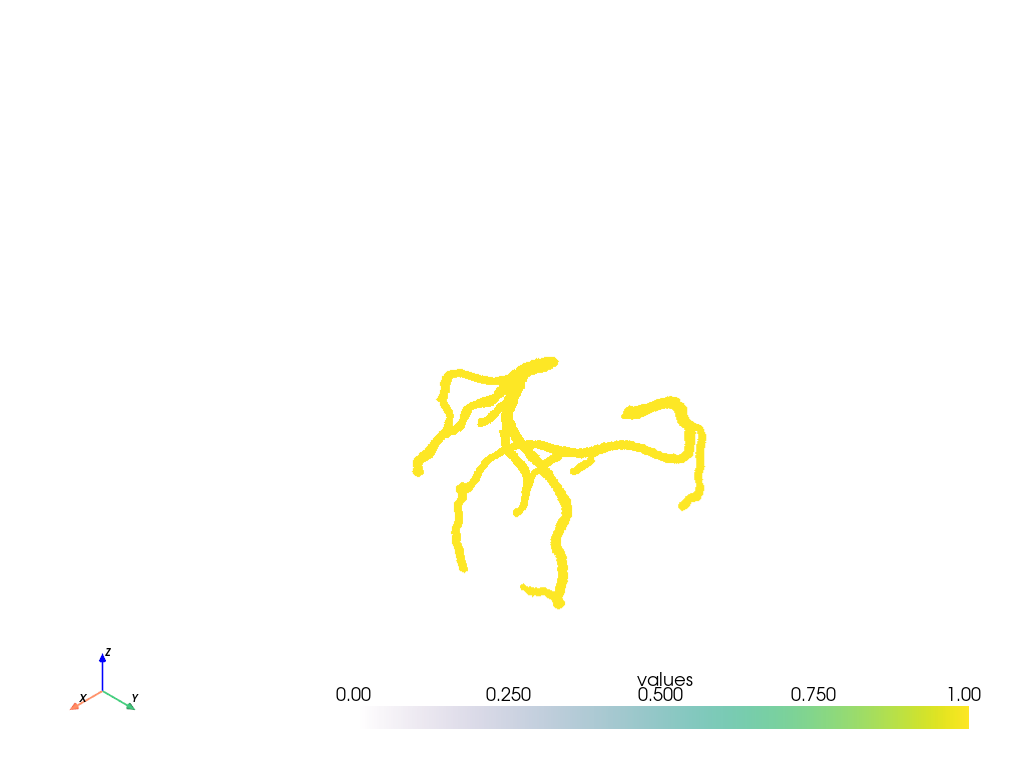

In [8]:
import pyvista as pv

data = pv.wrap(cta_volume)
data.plot(volume=True) # Volume render

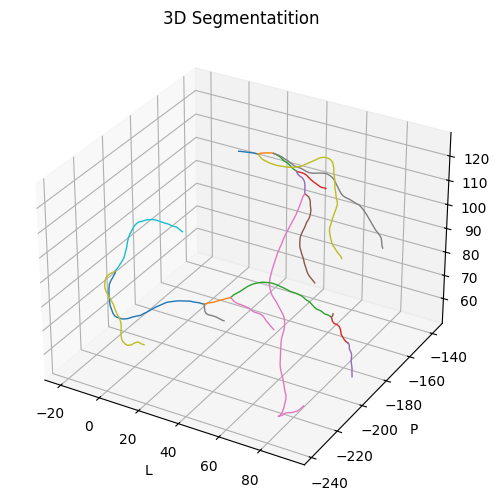

In [11]:

from mpl_toolkits.mplot3d import Axes3D
import glob

directory_path = 'C:\\Users\\nasre\\OneDrive\\Documenten\\MedicalImaging\\Segments_renamed\\Segments_renamed\\'
file_pattern = directory_path + 'SegmentPoints_0001_*.csv'

file_list = glob.glob(file_pattern)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for idx, file in enumerate(file_list):
    df = pd.read_csv(file)
    
    
    l = df['l']
    p = df['p']
    s = df['s']
    
    
    ax.plot(l, p, s, linestyle='-', linewidth=1)

# Add title and labels
ax.set_title('3D Segmentatition')
ax.set_xlabel('L')
ax.set_ylabel('P')
ax.set_zlabel('S')

# Show the plot
plt.show()


Sample 306 has a distance of 0.7484841346740723 which is above the threshold of 0.5201315879821777
Sample 470 has a distance of 1.1747024059295654 which is above the threshold of 0.5006218515336514


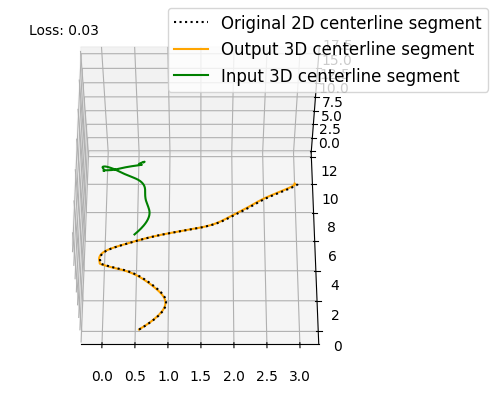

Number of samples: 2248
Mean time per sample: 0.53
Mean Projection Distance: 0.04
Standard deviation: 0.05


(0.03603718, 0.045756634)

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from data_loaders import create_datasets, CenterlineDatasetSpherical
from model import CARNet
from main import mPD_loss_2

# Ensure inline plotting
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() and torch.cuda.get_device_properties(0).total_memory > 5e9 else "cpu")

# Load the model
checkpoint = torch.load("D:\\CTA data\\models\\CAR-Net-Optimizer_trial0_checkpoint.pth")
model = CARNet().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

loss = mPD_loss_2()

# Load the data
train_loader, val_loader, test_loader = create_datasets(CenterlineDatasetSpherical(base_dir="D:\\CTA data\\"), train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=512, shuffle_train=False)

def evaluate_model(model, test_loader, loss, plot_outliers=False, std_threshold=10, nr_plots=1):
    model.eval()
    all_distances = []
    times = []
    for batch in test_loader:
        start = time.time()
        batch['origin_3D'] = batch['origin_3D'].to(device)
        batch['shape_3D'] = batch['shape_3D'].to(device)
        batch['origin_2D'] = batch['origin_2D'].to(device)
        batch['shape_2D'] = batch['shape_2D'].to(device)

        deformation_field = model(batch['origin_3D'], batch['shape_3D'], batch['origin_2D'], batch['shape_2D'])

        spherical_3D_deformed = batch['shape_3D'].clone()
        spherical_3D_deformed[:, 1:, :] = torch.add(spherical_3D_deformed[:, 1:, :], deformation_field)

        # Convert back to cartesian domain
        deformed_cart_3D = loss.cartesian_tensor(batch['origin_3D'], spherical_3D_deformed)
        original_cart_3D = loss.cartesian_tensor(batch['origin_3D'], batch['shape_3D'])
        original_cart_2D = loss.cartesian_tensor(batch['origin_2D'], batch['shape_2D'])
        end = time.time()
        times.append(end - start)

        deformed_3D = deformed_cart_3D.clone().detach().cpu().numpy()
        original_3D = original_cart_3D.clone().detach().cpu().numpy()
        original_2D = original_cart_2D.clone().detach().cpu().numpy()
        # Remove z component
        difference = abs(deformed_3D - original_2D)
        difference = difference[:, :2, :]

        # Pythagorean theorem
        distances = np.mean(np.sqrt(np.sum(difference ** 2, axis=1)), axis=1)
        all_distances.extend(distances)
        standard_deviation = np.std(all_distances)
        threshold = np.mean(all_distances) + std_threshold * standard_deviation
        for idx, distance in enumerate(distances):
            if distance > threshold:
                print(f"Sample {idx} has a distance of {distance} which is above the threshold of {threshold}")
                if plot_outliers == True:
                    plot_3D_centerline(original_3D, deformed_3D, original_2D, distances, idx)
        # Plot random sample

    plot_3D_centerline(original_3D, deformed_3D, original_2D, distances, nr_plots)
    print(f"Number of samples: {len(all_distances)}")
    mPD = np.mean(all_distances)
    std_mPD = np.std(all_distances)
    print(f"Mean time per sample: {np.mean(times):.2f}")
    print(f"Mean Projection Distance: {mPD:.2f}")
    print(f"Standard deviation: {std_mPD:.2f}")
    return mPD, std_mPD

def plot_3D_centerline(original_3D, deformed_3D, original_2D, distances, n_plots=1):
    fig = plt.figure(figsize=(6, 4))
    handles, labels = [], []
    idx = 0  # Select the first sample for plotting
    org_x = original_2D[idx, 0, :]
    org_y = original_2D[idx, 1, :]

    def_x = deformed_3D[idx, 0, :]
    def_y = deformed_3D[idx, 1, :]
    def_z = deformed_3D[idx, 2, :]

    org_x_3 = original_3D[idx, 0, :]
    org_y_3 = original_3D[idx, 1, :]
    org_z_3 = original_3D[idx, 2, :]

    ax = fig.add_subplot(111, projection='3d')

    # Extract the corresponding points for the selected sample
    original_2D_sample = original_2D[idx]
    deformed_3D_sample = deformed_3D[idx][:2, :]  # Select only the first two dimensions (x and y)

    # Extract x, y, z coordinates from the input arrays
    org_x, org_y = original_2D_sample[0, :], original_2D_sample[1, :]
    org_z = np.zeros_like(org_x)  # Set Z to zero to maintain 2D

    def_x, def_y = deformed_3D_sample[0, :], deformed_3D_sample[1, :]
    def_z = np.zeros_like(def_x)  # Set Z to zero to maintain 2D

    # Plot the original and deformed lines
    line2, = ax.plot(def_x, def_y, def_z, color='orange', label='Output 3D centerline segment')
    line1, = ax.plot(org_x, org_y, org_z, color='black', linestyle=':', label='Original 2D centerline segment')
    line3, = ax.plot(org_x_3, org_y_3, org_z_3, color='green', label='Input 3D centerline segment')

    # Collect handles and labels
    handles.extend([line1, line2, line3])
    labels.extend(['Original 2D centerline segment', 'Output 3D centerline segment', 'Input 3D centerline segment'])

    ax.text2D(0.05, 0.95, f"Loss: {distances[idx]:.2f}", transform=ax.transAxes)

    ax.view_init(elev=55, azim=-90)

    fig.legend(handles[:3], labels[:3], loc='upper right', fontsize='large')
    # Show the plot
    plt.tight_layout()
    plt.show()

evaluate_model(model, val_loader, loss, plot_outliers=False, std_threshold=10, nr_plots=1)
